# Artificial Intelligence :  Computer Assignment 3 - Naive Bayes Classifier
> __Morteza Nouri, 810198481__

## Goals:
- Usage of Naive Bayes theorem
- analyzing and classifying text
- 

## Description:
> In this project we want to classify the magazines in [DigiKala](‫‪https://www.digikala.com/mag/‬‬).


## Part 1: Preprocess
In this part I use [hazm library](https://www.roshan-ai.ir/hazm/) to process persian text in dataset. At first I remove all useless words(stopwords and punctuations) in the data then processing text using methods below:<br>
- __Normalization:__ normalize and adjust spaces.
- __Steamming:__ remove prefix and postfix of a word to find it's root.
- __Lemmatization__: except removing postfix and prefix of word, it will verify that root to be correct in meaning.
 
 __Q1__: In our text we might see a word in different forms(e.g. Plural, singular), but they are from same root and can have same effect in our classification. According to methods mentiond above, I decide to use Normalization and Lemmatization. Lemmatization gives us __Bon-e-Maazi__ and __Bon-e-Mozare__ of a verb in persian language and two words which have same root, in most cases have same concept.<br>
 _Note: Steaming is not accurate, because in some cases it destructs the normal form of the word. So I prefer to use Lemmatization instead that gives better perfomance and reduces the count of words in our bag._


In [17]:
import pandas as pd
import hazm
import re

numbers = ['۹', '۸', '۷', '۶', '۵', '۴', '۳', '۲', '۱', '۰' , '۱۰']
symbols = ['.', '،', '؛', '[', ']', '{', '}', '(', ')', '?', '!', ':', ';', '\"', '\'', '*', '/', '+',
       '%','٪', '؟' , '#', '@','-', '_', '\r\n', '\n', '«', '»', '>', '<', '=','.', '...', ]

common_words = [ 'یک','آن','آنها','سال', 'استفاده', 'قرار', 'آن ها', 'ها', 'میشود', 'می']
stopwords = set(hazm.stopwords_list() + numbers + symbols + common_words)

normalizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()
tokenizer = hazm.WordTokenizer()

def ngram(n, items):
    return [' '.join(items[n * i: n * i + n]) for i in range(len(items)//n)] + [' '.join(items[len(items)//n:])]

def preprocess_util(text):
    text = re.sub(r'[\u200c]', ' ', text)
    text = normalizer.normalize(text)
    text = tokenizer.tokenize(text)
    words = []
    for word in text:
        if not (word in stopwords):
            words.append(lemmatizer.lemmatize(word))
    return ngram(3, words)

def preprocess(data):
    for i in range(len(data)):
        data['content'][i] = preprocess_util(data['content'][i])
    data[['content']] = data[['content']].applymap(pd.Series)
    return data


In [18]:
train_df = pd.read_csv('Data/train.csv')
train_df['content'].fillna(train_df['label'], inplace=True)

train_df = preprocess(train_df)
train_df

,content,label
0,0 فیلم اکرا...,هنر و سینما
1,0 فیلمسازی کوئنتین...,هنر و سینما
2,0 جا...,علم و تکنولوژی
3,0 احتمال پش...,علم و تکنولوژی
4,0 دزد مغاز...,هنر و سینما
...,...,...
5195,0 امپراط...,سلامت و زیبایی
5196,0 ارتباطات اثر...,سلامت و زیبایی
5197,0 اپل ۲...,علم و تکنولوژی
5198,0 مارتینز بل...,سلامت و زیبایی


## Part 2: Process
We use bag of words method for magazine content to count words related to category. <br>

__Q2:__ 
- $c$: Magazine category. 
- Evidence $x$: Number of appearences of word. by seeing evidence we want to calculate posterior probability.
- Likelihood $p(x|c)$: Probability of having evidence in category c. This probability computed by means of given dataset.
- Prior $p(c)$: Probability of seeing magazine with category $c$.It is equal for all categories since they all have occured the same number of times in the dataset.(see above)
- Posterior $p(c|x)$ : Probability of belonging magazine to $c$ which results in the word $x$ has appeared in the magazine.We use this probability to classify.

In [19]:
def frequency_df(data):
    df = pd.DataFrame()
    grouped = data.groupby(data.label).apply(lambda x : pd.concat(x.content.values, ignore_index=True))    
    for k in data['label'].unique():
        df.loc[k, grouped[k].unique()] = grouped[k].value_counts()[grouped[k].unique()]
    df = df.fillna(0)
    return df

In [20]:
train_freq = frequency_df(train_df)

## Part 3: Bigrams
__Q3:__ 
- شیر سلطان جنگل است
- شیر سرشار از کلسیم است

In the above sentences, by using unigram, we can not distinguish 'شیر' meanings. If we use bigrams the different meanings of the 'شیر' can be distinguished properly.(maybe using bigrams in second sentence cause ambiguity thus 3-grams is better choice!) <br>

__Note:__ _I use 3-grams._



## Part 4: ‫‪Additive‬‬ ‫‪Smoothing‬‬
__Q4:__ If word w in our test dataset was not appeared in content of category c, probability of belonging to that category would be zero, So the likelihood will be zero and according to the $p(x_1|c)*p(x_2|c)*...*p(x_n|c)$ in Naive Bayes theorem, $p(c|x) = 0$.<br>

__Q5:__ 
$$ P_\alpha(x_i | c) = \frac {x_i + \alpha}{N + \alpha D} $$
where :
- $P_\alpha(x_i | c)$ is additive smoothed probability of evidence $x_i$ in category c.
- $x_i$ is number of all appearences of a word in category c.
- $\alpha$ is additive smoothing.
- $N$ is total number of words in category c.
- $D$ is number of features(here, distinct words in category c).

_Note:_ By assuming $\alpha = 0$ may get $p(x_i|c) = 0$, but with $\alpha > 0$ we guarantee that $ p(x_i|c) > 0$.

## Verifying Correctness
__Q6:__ We know that if we have words which they are frequent in all categories, these words cann't be usefull for prediction. Our task is to remove these words for domain.


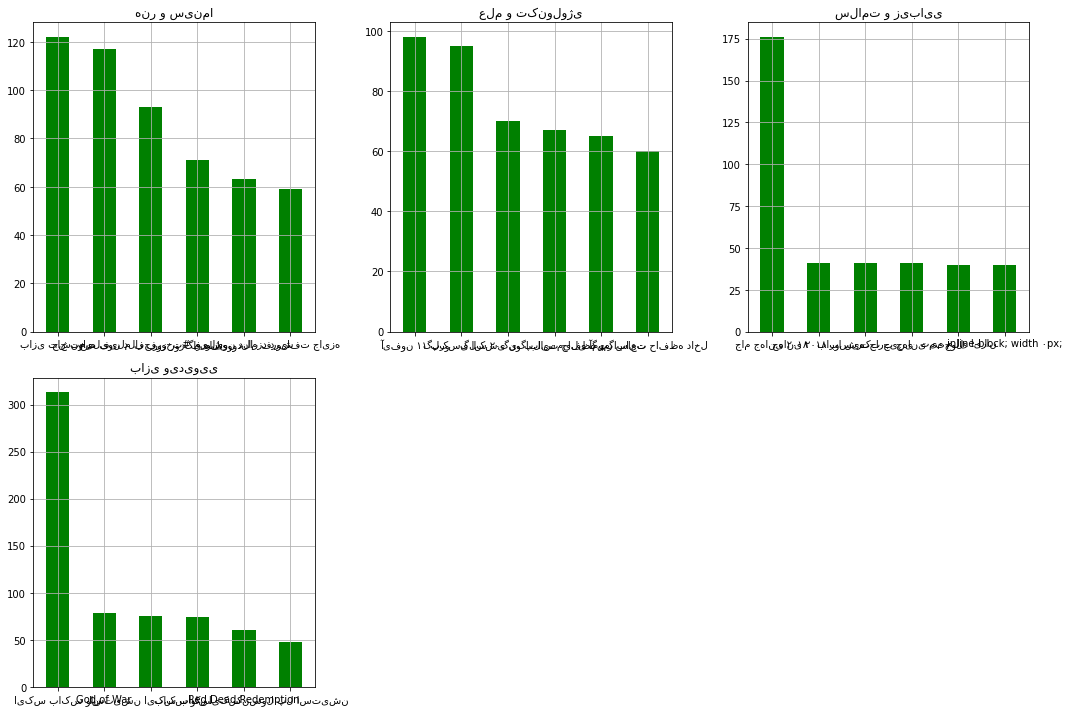

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

i = 0
for label, row in train_freq.iterrows():
    plt.subplot(2, 3, i + 1)
    x = row.nlargest(6)
    plt.bar(x.index, x.values , color='green', width=0.5)
    plt.title(x.name)
    plt.grid()
    i += 1

plt.tight_layout()
plt.show()

## Evaluation Metrics
__Q7:__ Assume you predict there are 100 magazines in 'علم و تکنولوژی' correctly. Now if we have 100 'علم و تکنولوژی' magazines in our model we get $100\%$ recall, but consider a situation where you predict 100000 magazines which are incorrectly in 'علم و تکنولوژی', So we get $0.1\%$ precision. In contract, assume you detect 100 magazines and you predict all in 'علم و تکنولوژی' correctly, So we get $100\%$ precision. If there are 100000 'علم و تکنولوژی' magazines in our model, we get the $0.1\%$ recall. In ideal way, we want to maximize both of metrics but in real world there is a tradeoff between them.(F1 metric in Q8)<br><br>

__Q8:__ F1 Score is the harmonic mean of Precision and Recall. This mean method, gives more weight to small numbers. In this way if one of numbers is 0, then F1 = 0, thus both of numbers should be large to get large F1 and large F1 means we have large precision and recall.<br><br>

__Q9:__ 
- __Micro:__ this is accuracy.
- __Macro:__ $\frac{F1_1 + F1_2 + ... + F1_n}{n}$, where $n$ is number of classes and $F1_i$ is corresponding $F1$ value.
- __Weighted:__ $\frac{a_1F1_1 + a_2F1_2 + ... + a_nF1_n}{n}$, where $a_i$ is number of samples of class $i$ in model.

In [22]:
def evaluate(test):
    df = pd.DataFrame()
    total = len(test)
    correct_detected = len(test.loc[test['label'] == test['Predicted Class']])
    
    macrof1 = 0;
    weightedf1 = 0;
    
    for i in test['label'].unique():
        correct_detected_class = len(test.loc[(test['label'] == test['Predicted Class']) & (test['label'] == i)])
        detected_class = len(test.loc[test['Predicted Class'] == i])
        total_class = len(test.loc[test['label'] == i])
        
        percision = correct_detected_class / detected_class
        recall = correct_detected_class / total_class
        
        f1 = 2 * (percision * recall) / (percision + recall) if (percision + recall != 0) else 0
        
        macrof1 += f1;
        weightedf1 += total_class * f1;
        df.loc['percision', i] = percision
        df.loc['recall', i] = recall
        df.loc['f1', i] = f1
    
    df.loc['accuracy', 'All Classes'] = correct_detected / total;
    df.loc['micro-f1', 'All Classes'] = correct_detected / total;
    df.loc['weighted-f1', 'All Classes'] = weightedf1 / total;
    df.loc['macro-f1', 'All Classes'] = macrof1 / len(test['label'].unique());
    return df

## Evaluation

In [23]:
test_df = pd.read_csv('Data/test.csv')
test_df = preprocess(test_df)
test_df

,content,label
0,0 صبحانه...,سلامت و زیبایی
1,0 نمایشگر گو...,علم و تکنولوژی
2,0 سلبریتی‌های ها...,هنر و سینما
3,0 گوگل اس...,بازی ویدیویی
4,0 ویژگی ج...,علم و تکنولوژی
...,...,...
797,0 برادر ...,هنر و سینما
798,0 Death Stran...,بازی ویدیویی
799,0 حال...,بازی ویدیویی
800,0 ...,علم و تکنولوژی


In [24]:
def calc_conditional_probs(row, prob_table):
    result = {}
    for i in prob_table.index:
            result[i] = 1/4 * prob_table.loc[i, prob_table.columns.intersection(list(row))].product()
    return result

def estimate(r):
    global prob_table
    result = calc_conditional_probs(r, prob_table)
    return max(result, key=result.get)


### Additive Smooth

In [25]:
alpha = 0.4
prob_table = (train_freq + alpha) / (train_freq.values.sum() + alpha)

additive_test = test_df.copy()
additive_test['Predicted Class'] = additive_test['content'].apply(estimate)
additive_res = evaluate(additive_test)
display(additive_test)
display(additive_res)

,سلامت و زیبایی,علم و تکنولوژی,هنر و سینما,بازی ویدیویی,All Classes
percision,0.908397,0.949612,0.710407,0.932292,NaN
recall,0.739130,0.884477,0.940120,0.908629,NaN
f1,0.815068,0.915888,0.809278,0.920308,NaN
accuracy,NaN,NaN,NaN,NaN,0.872818
micro-f1,NaN,NaN,NaN,NaN,0.872818
weighted-f1,NaN,NaN,NaN,NaN,0.874535
macro-f1,NaN,NaN,NaN,NaN,0.865136


### Without Additive Smooth

In [26]:
alpha = 0
prob_table = (train_freq + alpha) / (train_freq.values.sum() + alpha)

normal_test = test_df.copy()
normal_test['Predicted Class'] = normal_test['content'].apply(estimate)
normal_res = evaluate(normal_test)
display(normal_test)
display(normal_res)

,سلامت و زیبایی,علم و تکنولوژی,هنر و سینما,بازی ویدیویی,All Classes
percision,0.913043,0.944056,0.361233,0.946903,NaN
recall,0.521739,0.487365,0.982036,0.543147,NaN
f1,0.664032,0.642857,0.528180,0.690323,NaN
accuracy,NaN,NaN,NaN,NaN,0.610973
micro-f1,NaN,NaN,NaN,NaN,0.610973
weighted-f1,NaN,NaN,NaN,NaN,0.634888
macro-f1,NaN,NaN,NaN,NaN,0.631348


## Conclusion

__Q11:__ As we can saw in above tables, additive smoothing increases the accuracy. by checking f1 value for classes, we can obsever that if both metrics (precision and recall) grow up, then accuracy will grow up too.



In [36]:
misclassifed = additive_test[additive_test['label'] != additive_test['Predicted Class']]
display(misclassifed.head())

                                              content           label  \
8   0                                      گفت#گو ...    بازی ویدیویی   
20  0                                    پیشنهاد ت...  سلامت و زیبایی   
23  0                                   رادیوپل وی...     هنر و سینما   
48  0                                     شرکت تاک...  علم و تکنولوژی   
49  0                                      نمودار ...  علم و تکنولوژی   

   Predicted Class  
8      هنر و سینما  
20     هنر و سینما  
23    بازی ویدیویی  
48     هنر و سینما  
49  سلامت و زیبایی  
